In [277]:
# general dependencies for Python and MNE (Python native fNIRS wavelet analysis)
import numpy as np
import pandas as pd
import mne
import os
from glob import glob
from itertools import compress
from tqdm import tqdm

In [278]:
#Python version
from platform import python_version
python_version()

'3.7.5'

In [279]:
#dependencies for PyCWT, another wavelet analysis package
import pycwt as wavelet
from pycwt.helpers import find

In [280]:
import io
from copy import copy
from collections import OrderedDict
import requests

In [281]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [282]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../../..')
from LCBDtools.src import argParser
from LCBDtools.src import Plots

In [283]:
# Important configuration variables
study_dir = "/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean"
participant_num_len = 4 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset

# set block durations (these are actually trial durations, an entire block was 4 trials, approx 480 seconds for each dyad)
durations = {
    'Block 1': 120,
    'Block 2': 105,
    'Block 3': 120}

In [284]:
# set the channels for each ROI
ROIs = {
    'Left Frontal': ['S3_D2 hbo', 'S4_D2 hbo'],
    'Right Frontal': ['S5_D3 hbo', 'S6_D3 hbo'],
    'Left Temporal': ['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo'],
    'Right Temporal': ['S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo']}

In [285]:
# make a list of all matching session paths for each subject
session_dirs = [d for d in glob(study_dir+"/*/*_fNIRS")]

subjects = list(set([os.path.basename(d)[:participant_num_len] for d in session_dirs]))

In [286]:
session_dirs

['/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5016_N/5016_N_Child_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5016_N/5016_N_Parent_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5098_N/5098_N_Parent_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5098_N/5098_N_Child_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5124_N/5124_N_Child_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5124_N/5124_N_Parent_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5082_N/5082_N_Parent_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5082_N/5082_N_Child_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5075_N/5075_N_Child_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5075_N/5075_N_Parent_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5065_N/5065_N_Parent_fNIRS',
 '/data/perlman

In [287]:
len(session_dirs)

154

In [288]:
len(session_dirs)/2

77.0

In [289]:
# make a list where all of the scans will get loaded into
scans = []

# loop over all the session directories (dyads / DB-DOS folders)
for dyad_dir in list(set([os.path.split(ses)[0] for ses in session_dirs])):
    try:
        
        # get subject and visit from this path
        sub = os.path.basename(dyad_dir)[:participant_num_len]
        visit = os.path.basename(dyad_dir)

        # determining whether sub is Child or Parent can be done by reading the config file in the .nirx directory        
        config_files = glob(os.path.join(dyad_dir, "*fNIRS", "*config*"))

        # open the file and read the line with Subject= in it
        for config in config_files:
            with open(config, 'r') as f:
                line = f.readline()
                while "Subject=" not in line:
                    line = f.readline()
                line = line.strip()
                line = line.replace("Subject=", "")
                
                # if the line is 1 it's the child
                if line == "1":
                    sub1 = os.path.dirname(config) # child
                elif line == "2":
                    sub2 = os.path.dirname(config) # parent
                    
        # make sure it has 'modern' .evt files??? 
        evts = glob(sub1 + "/*.evt")
        if len(evts) != 2:
            print("There should be 2 evt files. Skipping:", os.path.basename(sub1))
            continue

#         # load each in via hypyp loader
        fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
        fnirs_participant_1.info['subject_info']['his_id'] = f"{sub[:participant_num_len]}c"
        
        fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
        fnirs_participant_2.info['subject_info']['his_id'] = f"{sub[:participant_num_len]}p"
        
        scans.append((fnirs_participant_1, fnirs_participant_2))
        
    except:
        print("skipping session:", dyad_dir)
        continue

There should be 2 evt files. Skipping: 5143_N_Child_fNIRS


/tmp/ipykernel_38069/2324312537.py:37: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_38069/2324312537.py:40: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_38069/2324312537.py:37: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_38069/2324312537.py:40: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_38069/2324312537.py:37: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warnin

In [290]:
scans

[(<RawNIRX | 5100_N_Child_fNIRS, 20 x 19284 (2468.2 s), ~31 kB, data not loaded>,
  <RawNIRX | 5100_N_Parent_fNIRS, 20 x 19284 (2468.2 s), ~31 kB, data not loaded>),
 (<RawNIRX | 5030_N_Child_fNIRS, 20 x 19062 (2439.8 s), ~31 kB, data not loaded>,
  <RawNIRX | 5030_N_Parent_fNIRS, 20 x 19062 (2439.8 s), ~31 kB, data not loaded>),
 (<RawNIRX | 5064_N_Child_fNIRS, 20 x 19376 (2480.0 s), ~31 kB, data not loaded>,
  <RawNIRX | 5064_N_Parent_fNIRS, 20 x 19376 (2480.0 s), ~31 kB, data not loaded>),
 (<RawNIRX | 5096_N_Child_fNIRS, 20 x 18530 (2371.7 s), ~31 kB, data not loaded>,
  <RawNIRX | 5096_N_Parent_fNIRS, 20 x 18530 (2371.7 s), ~31 kB, data not loaded>),
 (<RawNIRX | 5008_N_Child_fNIRS, 20 x 18573 (2377.2 s), ~31 kB, data not loaded>,
  <RawNIRX | 5008_N_Parent_fNIRS, 20 x 18573 (2377.2 s), ~31 kB, data not loaded>),
 (<RawNIRX | 5025_N_Child_fNIRS, 20 x 17466 (2235.5 s), ~31 kB, data not loaded>,
  <RawNIRX | 5025_N_Parent_fNIRS, 20 x 17466 (2235.5 s), ~31 kB, data not loaded>),
 (<R

In [291]:
len(scans)

76

In [292]:
#Basic identifying information for sample (first number sets the dyad, second number allows you to choose child (0) or parent(1))
scans[7][1]

<RawNIRX | 5144_N_Parent_fNIRS, 20 x 18435 (2359.6 s), ~31 kB, data not loaded>

In [293]:
# sets X value for data - gives data as an array below to be used later
X = scans[0][0].get_data()

In [294]:
# finds time index
t = scans[0][0].times

In [295]:
scans[0][0].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

In [296]:
scans[75][0].info['subject_info']

{'his_id': '5040c',
 'first_name': '5040-child',
 'sex': 0 (FIFFV_SUBJ_SEX_UNKNOWN),
 'birthday': (2021, 7, 15)}

In [297]:
#When you initially check annotations, you will notice a large number of STOP annotations (12 in our case) that needed to be removed
scans[0][0].annotations

<Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>

In [298]:
#if annotations don't match across subjects, need to check the evt files for consistency, run a event conversion script for the data
for scan in scans:
    print(scan[0].info['subject_info']['his_id'],scan[0].annotations)


5100c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5030c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5064c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5096c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5008c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5025c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5009c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5144c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5132c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5103c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5033c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5094c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5137c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5086c <Annotations | 24 segments: 1.0 (4), 128.0 (1

In [299]:
# rename events and set durations for all blocks

# if we can't load in the annotations right, we'll remove them from our list of scans
bads = []

for i, dscan in enumerate(scans):
    
    try:
        for scan in dscan:

            # rename the binary annotations with actual names
            scan.annotations.rename({
                '1.0': 'Block 1',
                '2.0': 'Block 2',
                '4.0': 'Block 3'})

            # remove any STOP annotations
            scan.annotations.delete(scan.annotations.description == '128.0')

            # set the durations based off the durations dictionary
            scan.annotations.set_durations(durations, verbose=True)
    
    except:
        bads.append(i)
        
for i in sorted(bads, reverse=True):
    del scans[i]

In [300]:
#stop durations are now removed and Blocks are now named correctly
scans[0][0].annotations

<Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>

In [301]:
from typing import Union

# function to do Continuous Wavelet Transform on a single signal
def mne_wavelet_transform(sig1: [mne.io.Raw, mne.Epochs], plot: bool = True,
                      chs: Union[str] = None):
    """
    Perform a continuous wavelet transform based off data in mne Raw object
    """
    
    # set time ##t0 = start time and dt = distance in time from t0. N is length
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
#     t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters ## Clayton Add reference for parameters? 
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
    
    for ch in chs:
        dat = np.squeeze(sig1.get_data(picks=[ch])) * 1e5
        
        # detrend and normalize the input data by its standard deviation
        p = np.polyfit(t - t0, dat, 1)
        dat_notrend = dat - np.polyval(p, t - t0)
        std = dat_notrend.std() # standard deviation
        var = std ** 2 # variance
        dat_norm = dat_notrend / std # normalized dataset
        
        alpha, _, _ = wavelet.ar1(dat) # lag-1 autocorrelation for red noise
        
        wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
            dat_norm, dt, dj, s0, J, mother)
        iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
    
        power = (np.abs(wave)) ** 2
        fft_power = np.abs(fft) ** 2
        period = 1 / freqs
        power /= scales[:, None] # optional according to Liu et al. (2007)
        
        # power significance test
        signif, fft_theor = wavelet.significance(
            1.0, dt, scales, 0, alpha,
            significance_level=0.95, 
            wavelet=mother)
        sig95 = np.ones([1, N]) * signif[:, None]
        sig95 = power / sig95
        
        # calculate global wavelet spectrum and determine its significance level
        glbl_power = power.mean(axis=1)
        dof = N - scales # correction for padding at edges
        glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                                significance_level=0.95, dof=dof,
                                                wavelet=mother)
        
        # calculate scale average and its significance level
        sel = find((period >= 10) & (period < 50))
        Cdelta = mother.cdelta
        scale_avg = (scales * np.ones((N, 1))).transpose()
        scale_avg = power / scale_avg # As in Torrence and Compo (1998) equation 24
        scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
        scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                                    significance_level=0.95,
                                                    dof=[scales[sel[0]],
                                                        scales[sel[-1]]],
                                                    wavelet=mother)
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} Channel {ch} Continuous Wavelet Transform"
            label = ""
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the original time series
            ax = plt.axes([0.1, 0.75, 0.65, 0.2])
            ax.plot(t, dat, 'k', linewidth=1.5)
            ax.set_title('a) {}'.format(title))
            ax.set_ylabel(r'{} [{}]'.format(label, units))
            
            # second sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
            levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            conmap = bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), 
                        extend='both', cmap=plt.cm.jet)
#             plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
            bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                                  extent=extent)
            bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
            bx.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            bx.set_yticks(np.log2(Yticks))
            bx.set_yticklabels(1/Yticks)
            
            # third sub-plot, the global wavelet and Fourier power spectra and theoretical
            # noise spectra. Note that period scale is logarithmic
            cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
            cx.plot(glbl_signif, np.log2(period), 'k--')
            cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
            cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
                    linewidth=1.)
            cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
            cx.set_title('c) Global Wavelet Spectrum')
            cx.set_xlabel(r'Power [({})^2]'.format(units))
            cx.set_xlim([0, glbl_power.max() + var])
            cx.set_ylim(np.log2([period.min(), period.max()]))
            cx.set_yticks(np.log2(Yticks))
            cx.set_yticklabels(1/Yticks)
            plt.setp(cx.get_yticklabels(), visible=False)
            
            # Fourth sub-plot, the scale averaged wavelet spectrum.
            dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
            dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
            dx.plot(t, scale_avg, 'k-', linewidth=1.5)
            dx.set_title('d) {}--{} second scale-averaged power'.format(2, 8))
            dx.set_xlabel('Time (seconds)')
            dx.set_ylabel(r'Average variance [{}]'.format(units))
            ax.set_xlim([t.min(), t.max()])

            plt.show()
    
    return wave, scales, freqs, coi, fft, fftfreqs


# function to do wavelet coherence transform on 2 signals
def mne_wavelet_coherence_transform(sig1: [mne.io.Raw, mne.Epochs],
        sig2: [mne.io.Raw, mne.Epochs],
        plot: bool = True, fig_fname: str = None,
        chs: Union[str] = None):
    
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
#     t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
        
    for ch in chs:
        dat1 = np.squeeze(sig1.get_data(picks=[ch]))
        dat2 = np.squeeze(sig2.get_data(picks=[ch]))
        
        if np.isnan(dat1).any():
            print("Dat 1 contains NaN values")
            raise ValueError
            
        if np.isnan(dat2).any():
            print("Dat 2 contains NaN values")
            raise ValueError
        
        # detrend and normalize the input data by its standard deviation
        p1 = np.polyfit(t - t0, dat1, 1)
        dat_notrend1 = dat1 - np.polyval(p1, t - t0)
        std1 = dat_notrend1.std() # standard deviation
        var1 = std1 ** 2 # variance
        dat_norm1 = dat_notrend1 / std1 # normalized dataset
        
        # detrend and normalize the input data by its standard deviation
        p2 = np.polyfit(t - t0, dat2, 1)
        dat_notrend2 = dat2 - np.polyval(p2, t - t0)
        std2 = dat_notrend2.std() # standard deviation
        var2 = std2 ** 2 # variance
        dat_norm2 = dat_notrend2 / std2 # normalized dataset
        
        WCT, aWCT, coi, freqs, sig95 = wavelet.wct(
            dat_norm1, dat_norm2,
            dt, dj=dj, s0=s0, J=J, sig=False,
            significance_level=0.95, wavelet='morlet',
            normalize=True)
        
        period = 1 / freqs
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} / {sig2.info['subject_info']['his_id']} Channel {ch} Wavelet Coherence Transform"
            label = f"{sig1.info['subject_info']['his_id']} {sig2.info['subject_info']['his_id']} {ch}"
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            ax = plt.axes([0.1, 0.37, 0.65, 0.28])
#             levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            levels = list(np.arange(0.1, 1, step=0.1))
            conmap = ax.contourf(t, np.log2(period), WCT, levels, 
                        extend='both', cmap=plt.cm.jet)
            plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
#             ax.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#                                   extent=extent)
            ax.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            ax.set_title('b) {} Wavelet Coherence Spectrum ({})'.format(label, mother.name))
            ax.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            ax.set_yticks(np.log2(Yticks))
            ax.set_yticklabels(1/Yticks)
            ax.set_xlim([t.min(), t.max()])
            ax.set_ylim(np.log2([period.min(), period.max()]))
            
            if fig_fname is None:
                plt.show()
            else:
                plt.savefig(fig_fname)
            
    return WCT, aWCT, coi, freqs, sig95 

In [302]:
scans[10][0].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

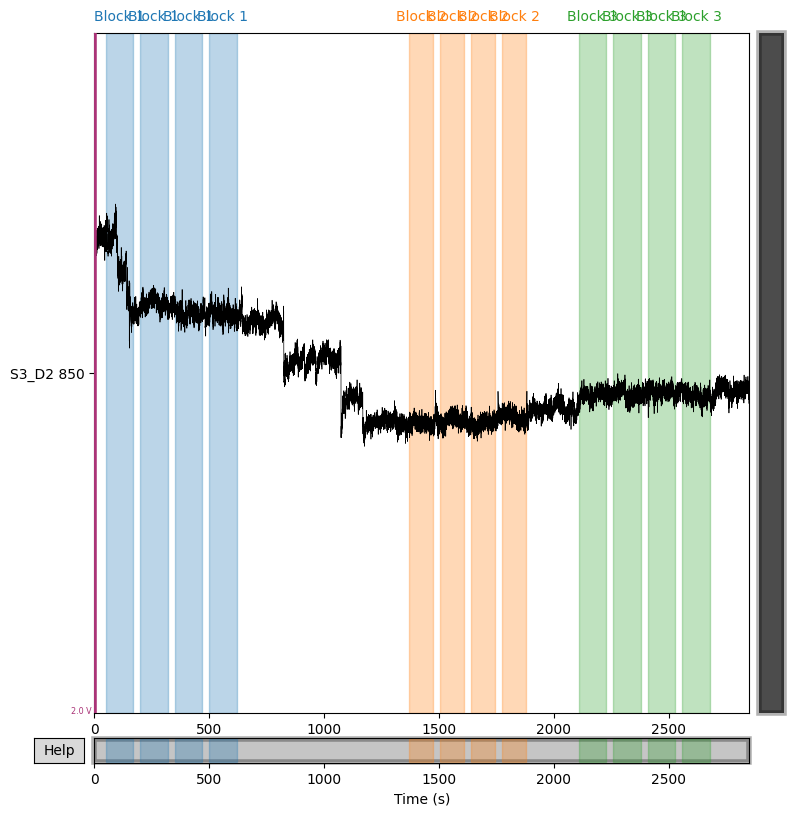

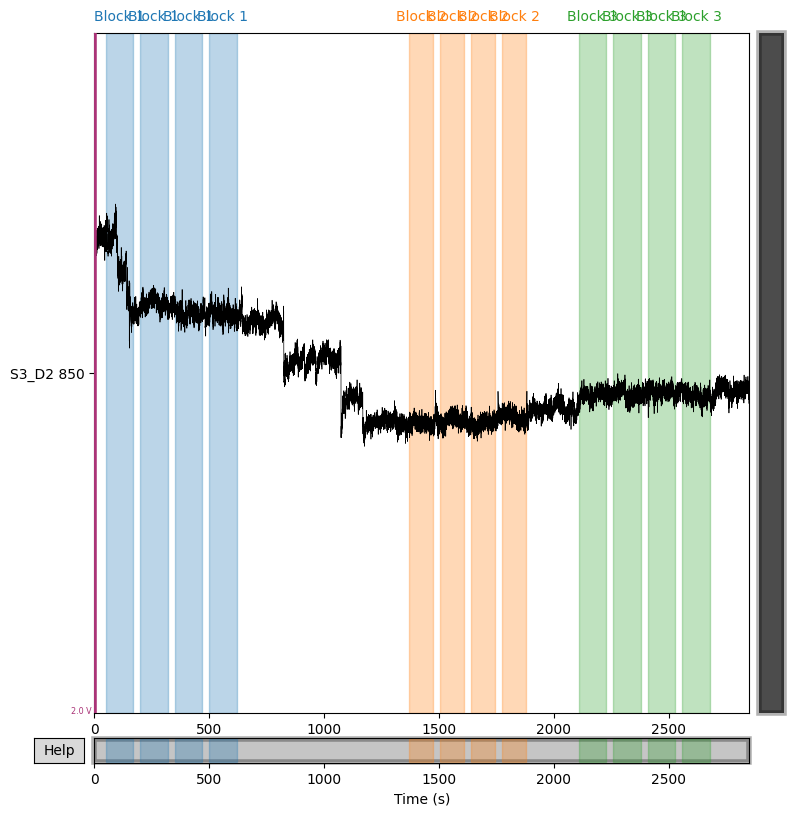

In [303]:
# example Block plot for 3000 seconds
scans[10][0].copy().pick(['S3_D2 850']).plot(duration=3000, scalings=1)

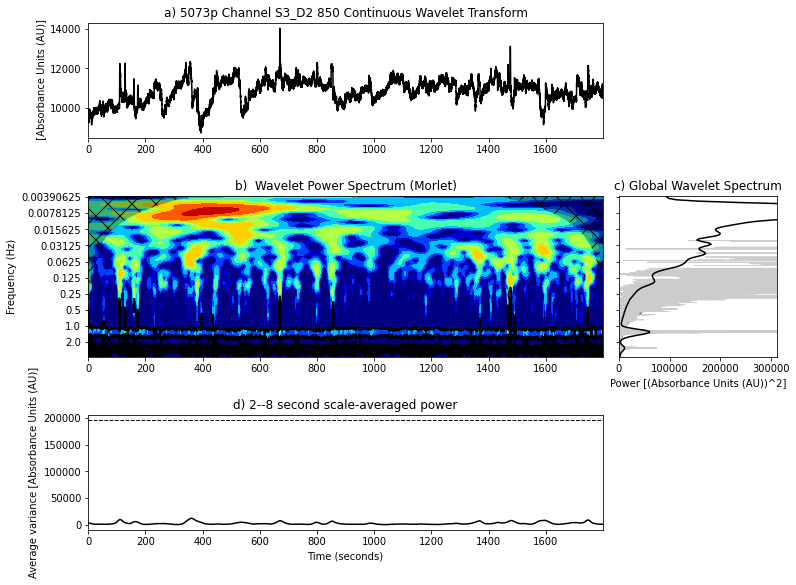

In [304]:
# example wavelet transform for 1800 seconds
wave, scales, freqs, coi, fft, fftfreqs = mne_wavelet_transform(
    scans[56][1].copy().crop(tmax=1800),
    plot=True,
    chs=['S3_D2 850']
)

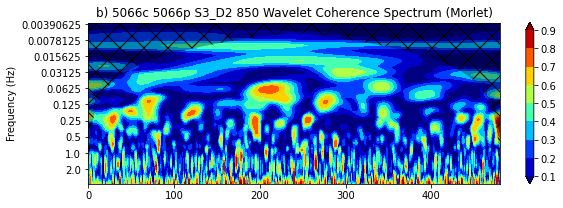

In [305]:
# example coherence transform from a real dyad with 400 seconds

WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    scans[25][0].copy().pick(['S3_D2 850']).crop(tmax=480),
    scans[25][1].copy().pick(['S3_D2 850']).crop(tmax=480),
    plot=True)

# Preprocessing Step

Now that data are loaded in and events are correctly distinct, we iterate through each dyad and each individual scan to apply LCBD-standard preprocessing functions. 
- Convert to Optical Density
- Record Scalp-Coupling Index and Mark Channels < 0.5
- Temporal Derivative Distribution Repair
- Beer Lambert Law to Convert to Haemoglobin
- Bandpass Filter 0.01-0.5 Hz

and append those dyads to a list of preprocessed scans. 

In [306]:
# make a list where the preprocessed scans will go
pps = []

# for each dyad scan in scans
for dscan in scans:

    ppdscan = [] # make a list for the preprocessed dyad's scans
    
    # individually preprocess each subject in dyad
    for scan in dscan:
        
        # convert to optical density
        raw_od = mne.preprocessing.nirs.optical_density(scan)

        # scalp coupling index
        sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
        raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))
        
        # linear detrend, par example
#         raw.data[:] = scipy.signal.detrend(raw.get_data(), axis=-1, fit='linear')

        #bad channel labelling
        if len(raw_od.info['bads']) > 0:
            print("Bad channels in subject", raw_od.info['subject_info']['his_id'], ":", raw_od.info['bads'])
        
        # temporal derivative distribution repair (motion attempt)
        tddr_od = mne.preprocessing.nirs.tddr(raw_od)
#         print("tddr")
#         tddr_od.plot(
#             n_channels=len(tddr_od.ch_names),
#             scalings=0.1,
#             duration=100,
#             show_scrollbars=False)
        
        # savgol filter (linear polynomial smoothing)
#         sav_od = raw_od.savgol_filter(0.5)
#         print("savgol filtering")
#         sav_od.plot(
#             n_channels=len(sav_od.ch_names),
#             scalings=0.1,
#             duration=100,
#             show_scrollbars=False)

        #bandpass filtering
        bp_od = tddr_od.filter(0.01, 0.5)
#         print("bandpass")
#         bp_od.plot(
#             n_channels=len(bp_od.ch_names),
#             duration=100,
#             scalings=0.1,
#             show_scrollbars=False)
    
        # haemoglobin conversion
        haemo = mne.preprocessing.nirs.beer_lambert_law(bp_od, ppf=0.1)
#         print("haemo")
#         haemo.plot(
#             n_channels=len(haemo.ch_names),
#             duration=100,
#             scalings=0.0001,
#             show_scrollbars=False)

#         print("PSD")
#         haemo_lp.plot_psd(average=True)
        
        ppdscan.append(haemo)
        
    pps.append(ppdscan)

Bad channels in subject 5064p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850']
Bad channels in subject 5096c : ['S3_D2 760', 'S3_D2 850']
Bad channels in subject 5096p : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 5008c : ['S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S5_D3 760', 'S5_D3 850', 'S6_D3 760', 'S6_D3 850', 'S7_D3 760', 'S7_D3 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 5008p : ['S6_D3 760', 'S6_D3 850', 'S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 5025p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 5132c : ['S3_D2 760', 'S3_D2 850']
Bad channels in subject 5103p : ['S3_D2 760', 'S3_D2 850']
Bad channels in subject 5033c : ['S3_D2 760', 'S3_D2 850']
Bad channels in subject 5033p : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 5137c : ['S5_D3 760', 'S5_D3 850', 'S6_D3 760', 'S6_D3 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 5086p : ['S7_D4

In [307]:
#Creating a dictionary variable to store bad channels for later
bad_channels_dict = {}

for dscan in pps:
    
    for scan in dscan:
        
        bads = scan.info['bads']
        bad_channels_dict[scan.info['subject_info']['his_id']] = \
            bads
        

In [308]:
bad_channels_dict['5016p']

['S1_D1 hbo', 'S1_D1 hbr']

In [309]:
pps[7][0].info['subject_info']

{'his_id': '5144c',
 'first_name': '5144-1',
 'sex': 0 (FIFFV_SUBJ_SEX_UNKNOWN),
 'birthday': (2022, 2, 15)}

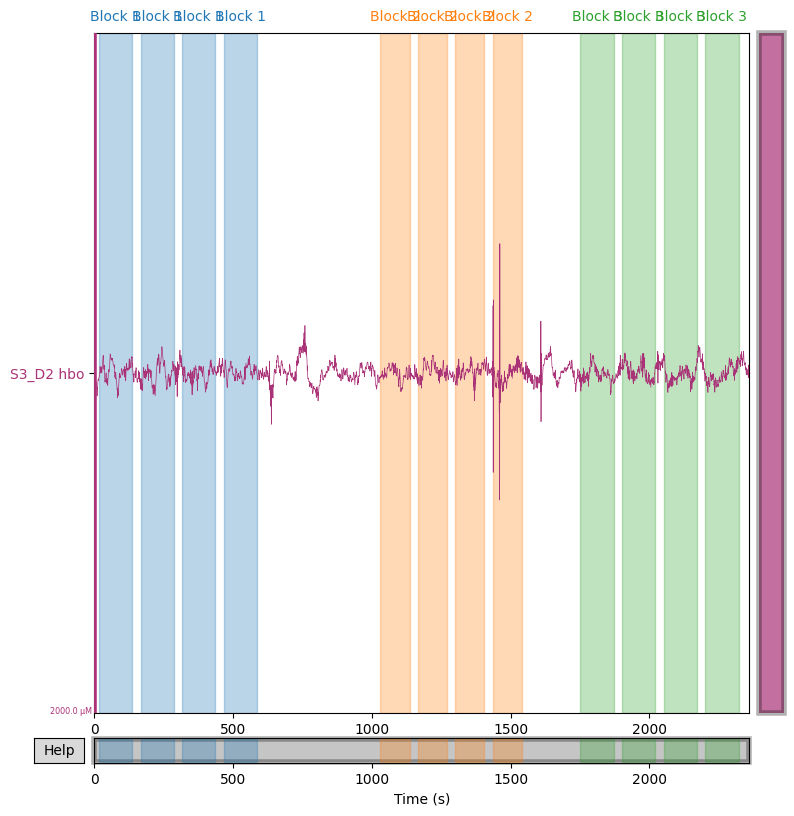

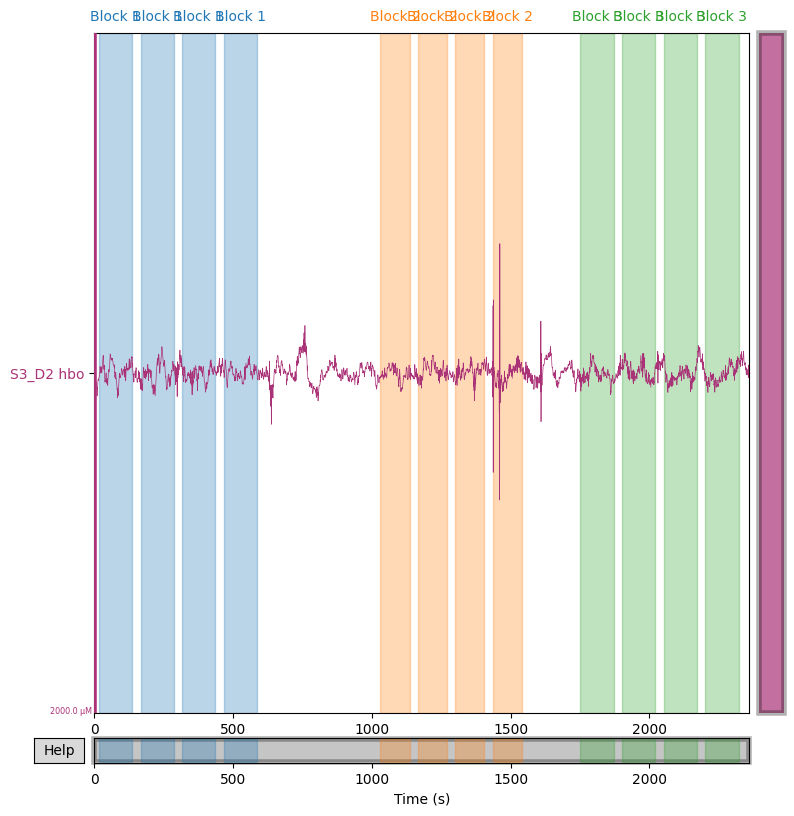

In [310]:
# example plot for 3000 seconds
pps[7][0].copy().pick(['S3_D2 hbo']).plot(duration=3000, scalings=0.001)

In [311]:
sampling_rate = pps[0][0].info['sfreq']
print(sampling_rate)

7.8125


In [312]:
# make a dictionary where all of the epoch'd data will go
epoch_df = {}

# loop over the dyads in the preprocessed list
for dscan in pps:
    
    # February 9th 2023
    # Clayton update to prune subjects who have
    # >= 10 channels dropped from the SCI function during preprocessing
    max_bad = max([len(scan.info['bads']) for scan in dscan])
    # whichever number is higher ^, num. of channels dropped in
    # either parent or child
    
    if max_bad >= 10:
        for scan in dscan:
            sub_num = scan.info['subject_info']['his_id']
            print("Subject {} was dropped from further analysis.".format(sub_num))
        
        continue # skip this dyad
        # if max_bad is greater than or equal to 10
    
    # for each scan in the dyad
    for scan in dscan:
    
        # set their location in the epoch df to a dictionary
        epoch_df[scan.info['subject_info']['his_id']] = {}
    
#        for i, ROI in enumerate(ROIs.keys()):

        # loop over ROIs (channels here)
        for i, ROI in enumerate([ch for ch in scan.info['ch_names'] if "hbo" in ch]):
            
            epoch_df[scan.info['subject_info']['his_id']][ROI] = []
        
            # get their events and set block durations
            events, event_dict = mne.events_from_annotations(dscan[0], verbose=False)
            reject_criteria = dict(hbo=200e-6)
            tmin, puzzletmax, playtmax = -5, 105, 120
            
            # use the mne.Epochs function / object to generate epochs
            preplay_epochs = mne.Epochs(
                scan, # the scan object
                events, # its events
#                 picks=ROIs[ROI],
                picks=[ROI], # the channels
                event_id={list(event_dict.keys())[0]: list(event_dict.values())[0]}, # the first event key
                tmin=tmin, # epoch relative start time
                tmax=playtmax, # epoch relative end time
                baseline= (None, 0), # baseline window to subtract
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1, # linear detrend
                verbose=False, 
                preload=False, # don't actually load it yet (saves memory)
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(preplay_epochs)
            
            puzzle_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[1]: list(event_dict.values())[1]},
                tmin=tmin,
                tmax=puzzletmax,
                baseline= (None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(puzzle_epochs)
            
            postplay_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[2]: list(event_dict.values())[2]},
                tmin=tmin,
                tmax=playtmax,
                baseline=(None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(postplay_epochs)

Subject 5008c was dropped from further analysis.
Subject 5008p was dropped from further analysis.
Subject 5049c was dropped from further analysis.
Subject 5049p was dropped from further analysis.
Subject 5066c was dropped from further analysis.
Subject 5066p was dropped from further analysis.
Subject 5076c was dropped from further analysis.
Subject 5076p was dropped from further analysis.


In [313]:
# here is the way to access information in the epoch dictionary

In [314]:
#Will telll you how many dyads are retaining for further analyses
len([sub for sub in epoch_df.keys() if "c" in sub])

72

In [315]:
# a single subject 
epoch_df['5064c']

{'S1_D1 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 3': 4>],
 'S2_D1 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 3': 4>],
 'S2_D2 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 se

In [316]:
# a specific channel from the subject
epoch_df['5064c']['S1_D1 hbo']

[<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 1': 4>,
 <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 2': 4>,
 <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 3': 4>]

In [317]:
# a specific block at that subject / channel, in this case the first (0) is pre-play
epoch_df['5064c']['S1_D1 hbo'][0]

Number of events,4
Events,Block 1: 4
Time range,-4.992 – 120.064 sec
Baseline,-4.992 – 0.000 sec


In [318]:
# a specific iteration/trial of that block at that subject / channel, in this case the first (0) is pre-play, we look at the 4th (3) iteration of the block
epoch_df['5064c']['S1_D1 hbo'][0][3]

Number of events,1
Events,Block 1: 1
Time range,-4.992 – 120.064 sec
Baseline,-4.992 – 0.000 sec


In [319]:
event_dict

{'Block 1': 1, 'Block 2': 2, 'Block 3': 3}

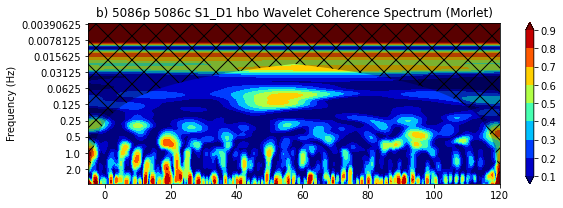

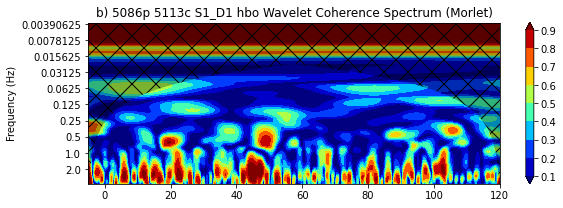

In [320]:
# example WCT between a real dyad, puzzle block (1), iteration/trial 0 (0)
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['5086p']['S1_D1 hbo'][2][3].copy(),
    epoch_df['5086c']['S1_D1 hbo'][2][3].copy(),
    plot=True)

# same WCT but a random false dyad
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['5086p']['S1_D1 hbo'][2][3].copy(),
    epoch_df['5113c']['S1_D1 hbo'][2][3].copy(),
    plot=True)

In [321]:
# list out all the subjects in the epoch df
epoch_df.keys()

dict_keys(['5100c', '5100p', '5030c', '5030p', '5064c', '5064p', '5096c', '5096p', '5025c', '5025p', '5009c', '5009p', '5144c', '5144p', '5132c', '5132p', '5103c', '5103p', '5033c', '5033p', '5094c', '5094p', '5137c', '5137p', '5086c', '5086p', '5055c', '5055p', '5111c', '5111p', '5039c', '5039p', '5034c', '5034p', '5123c', '5123p', '5106c', '5106p', '5056c', '5056p', '5015c', '5015p', '5133c', '5133p', '5036c', '5036p', '5003c', '5003p', '5145c', '5145p', '5071c', '5071p', '5065c', '5065p', '5113c', '5113p', '5060c', '5060p', '5101c', '5101p', '5043c', '5043p', '5063c', '5063p', '5004c', '5004p', '5102c', '5102p', '5046c', '5046p', '5075c', '5075p', '5047c', '5047p', '5010c', '5010p', '5044c', '5044p', '5068c', '5068p', '5077c', '5077p', '5083c', '5083p', '5098c', '5098p', '5122c', '5122p', '5069c', '5069p', '5053c', '5053p', '5057c', '5057p', '5097c', '5097p', '5118c', '5118p', '5005c', '5005p', '5119c', '5119p', '5115c', '5115p', '5073c', '5073p', '5082c', '5082p', '5067c', '5067p',

In [322]:
# delete things we don't need anymore to save memory (ONLY RUN THIS IF YOU NEED TO CONDUCT A NEW PERMUTATION ANALYSIS)
# del scans
# del pps

In [323]:
import random

In [324]:
# ATTENTION READ THE FOLLOWING COMMENT CAREFULLY BEFORE PROCEEDING

In [325]:
# for each parent

    # real kid's synchrony value
    
    # 80 false dyad synchrony values
    
    # 

In [ ]:
# make a new dictionary where the synchrony values will be stored
sync_df = {}
block_types = ['Block 1', 'Block 2', 'Block 3']
perm_df = {}

# THIS TAKES A REALLY LONG TIME TO COMPUTE. AROUND 14 HOURS ON A DECENT NETWORK
# SKIP DOWN TO USE THE SAVED VERSIONS!

#real vs single false dyad test of a myriad of real and fake dyad pairs

# for every parent subject
for parent in tqdm([sub for sub in sorted(epoch_df.keys()) if "p" in sub]):
    sync_df[parent] = {}
    perm_df[parent] = []
    
    # pick two children, one real and one random
    children = []
    
#     children.append(parent.replace("p", "c")) # real child
    
    # random sample of N children
    # could be repeated, could be the real dyad 
    randoms = random.choices(
        [sub for sub in epoch_df.keys() if "c" in sub],
        k=999) # N of random 
    # randoms = list(randoms).insert(0, parent.replace("p", "c"))
    perm_df[parent] = list(randoms)
    
    # only going to do synchrony once per kid
    # we can count # of repeats from perm_df[parent]
    for child in list(set(randoms)):
        children.append(child)
    
    # old version that just does 1 random non-real child per parent
#     children.append(
#         random.choice([sub for sub in epoch_df.keys() if "c" in sub \
#             and parent.replace("p", "") not in sub])) # random pick
    
    # loop over these 2 selected children (1 real, N random)
    for child in children:
        
        # and make them a location in the sync dictionary under this parent
        sync_df[parent][child] = {}
        
        # for every block type (pre-play, puzzle, post-play)
        for block_num, block in enumerate(block_types):
            
            # make this parent/child combo a location for this block type, also a dictionary
            sync_df[parent][child][block] = {}
                
            # for each channel available with this subject (not dropped)
            for ch in epoch_df[parent].keys():
                
                # our sync value is going to go here
                # sync_df[parent][child][block][ch]
                # i.e. averaging over the 4 block iterations
                
                # so start keeping track of values to average now
                pc_wcts = []
                
                # load in their epoched data for this subject / channel / block
                p_epoch = epoch_df[parent][ch][block_num].load_data()
                c_epoch = epoch_df[child][ch][block_num].load_data()
                
                # for each iteration of this block (max 4)
                for block_it in np.arange(0, np.min([
                    len(p_epoch),
                    len(c_epoch)])):
                    
                    # try to do the WCT with these epochs
                    try:
                        WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
                            p_epoch[block_it],
                            c_epoch[block_it],
                            plot=True if "S5_D3" in ch else False, # save plots but only for some random channel because otherwise it's an insane amount
                            fig_fname=f"/data/perlman/moochie/analysis/eDOC_NARSAD/sync_figs/{parent}_{child}_{ch.replace(' ', '_')}_{block_num}_{block_it}.png")

                        # make values outside COI = np.nan
                        nanWCT = WCT
                        for t in range(nanWCT.shape[1]):
                            nanWCT[np.where(freqs>coi[t]), t] = np.nan
                        # also set to nan outside frequencies of interest
                        
                        # TASK RELATED FREQUENCIES ARE ARBITRARILY DETERMINED here
                        WCT[(2>(1/freqs))|((1/freqs)>13), :] = np.nan
                        
                        # between periods of 2s and 13s (.08 -.5 Hz; flip for sec) which is based on Reindl et al 2018 paper (in Reindl study a single trial typcially took 5-8 sec)
                        #also in Reindl paper, significant coherence values were identifed above .65 (can be between 0 and 1)
                       

                        # average inside cone of influence
                        # and within values from freq range determined above
                        pc_wcts.append(np.nanmean(nanWCT))
    #                     print(np.nanmean(nanWCT))
    
                    # if anything with the WCT fails, say so
                    except:
                        print(f"Fail @ parent {parent}, child {child}, block {block}, channel {ch}, block it {block_it}")
#                 print(np.average(pc_wcts))  
                sync_df[parent][child][block][ch] = np.average(pc_wcts)

 11%|██████████████████▏                                                                                                                                                 | 8/72 [1:24:37<11:21:12, 638.64s/it]

In [327]:
list(sync_df['5056p']['5056c']['Block 1'].values())

KeyError: '5056p'

In [328]:
#important to set channels here
channels = epoch_df[parent].keys()

In [329]:
epoch_df['5005p']

{'S1_D1 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 3': 4>],
 'S2_D1 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 3': 4>],
 'S2_D2 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 se

In [185]:
channels

dict_keys(['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo', 'S3_D2 hbo', 'S4_D2 hbo', 'S5_D3 hbo', 'S6_D3 hbo', 'S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo'])

In [ ]:
#Can use this to check that this variable has been created (important so you can save it in the next step) but the output is very long so clear the output before you continue
sync_df

In [245]:
# skip if you're going to load the already-saved ones. for real. don't overwrite this with an empty data file. 
# SAVE SYNCHRONY VALUES

import json
json_object = json.dumps(sync_df, indent=4)

with open("/data/perlman/moochie/analysis/eDOC_NARSAD/Clean_Analysis/wct_permuted_values.json", 'w') as outfile:
    json.dump(sync_df, outfile)
    
    
# also save as CSV
import pandas as pd

cols = ["Parent", "Child", "Block"]
for ch in channels:
    cols.append(ch)
    
df = pd.DataFrame(columns=cols)    

for parent in sync_df.keys():
    
    for child in sync_df[parent].keys():
        
        for block in sync_df[parent][child].keys():
            
            dic = {
                'Parent': parent,
                'Child': child,
                'Block': block}
            
            for key, val in sync_df[parent][child][block].items():
                dic[key] = val
            
#             print(dic)
            df = df.append(dic, ignore_index=True)
        
print(df)
df.to_csv("/data/perlman/moochie/analysis/eDOC_NARSAD/Clean_Analysis/wct_permuted_values.csv")

      Parent  Child    Block  S1_D1 hbo  S2_D1 hbo  S2_D2 hbo  S3_D2 hbo  \
0      5003p  5132c  Block 1   0.229761   0.265946   0.239572        NaN   
1      5003p  5132c  Block 2   0.258742   0.242556   0.255552        NaN   
2      5003p  5132c  Block 3   0.230602   0.217988   0.242500        NaN   
3      5003p  5053c  Block 1   0.246677   0.248538   0.231828   0.219819   
4      5003p  5053c  Block 2   0.246050   0.255225   0.308526   0.276852   
...      ...    ...      ...        ...        ...        ...        ...   
15547  5150p  5025c  Block 2   0.253498   0.264801   0.236560   0.266582   
15548  5150p  5025c  Block 3   0.229008   0.222030   0.249612   0.269144   
15549  5150p  5020c  Block 1   0.234503   0.251073   0.274274   0.251234   
15550  5150p  5020c  Block 2   0.249891   0.296169   0.284807   0.290199   
15551  5150p  5020c  Block 3   0.243561   0.238718   0.261131   0.240788   

       S4_D2 hbo  S5_D3 hbo  S6_D3 hbo  S7_D3 hbo  S7_D4 hbo  S8_D4 hbo  
0       0.256

In [246]:
# Save permuted values

json_object = json.dumps(perm_df, indent=4)
with open("/data/perlman/moochie/analysis/eDOC_NARSAD/Clean_Analysis/permuted_subjects.json", 'w') as outfile:
    json.dump(perm_df, outfile)

In [330]:
# LOAD PERMUTED SYNCHRONY VALUES from the saved file, saving time and precious CPU-hours

import json
with open("/data/perlman/moochie/analysis/eDOC_NARSAD/Clean_Analysis/permuted_subjects.json", 'r') as infile:
    perm_df = json.load(infile)

In [331]:
# LOAD REAL SYNCHRONY VALUES from the saved file, saving time and precious CPU-hours

import json
with open("/data/perlman/moochie/analysis/eDOC_NARSAD/Clean_Analysis/wct_permuted_values.json", 'r') as infile:
    sync_df = json.load(infile)

In [334]:
# how many parents are in there (some may be repeated because they have multiple children in the study)
len(sync_df.keys())

72

In [335]:
# how many parents are in there, without repeats
len(set([sub[:-1] for sub in list(sync_df.keys())]))

72

In [336]:
#THE BEGINNING OF REAL VS FALSE DYADS STATS

In [337]:
# Subject 5049c was dropped from further analysis.
# Subject 5049p was dropped from further analysis.
# Subject 5066c was dropped from further analysis.
# Subject 5066p was dropped from further analysis.
# Subject 5076c was dropped from further analysis.
# Subject 5076p was dropped from further analysis.
# Subject 5008c was dropped from further analysis.
# Subject 5008p was dropped from further analysis.

# bad_subs = ['5049', '5066', '5076', '5008']

# parents = [parent for parent in sync_df.keys()]
# for parent in parents:
    
#     children = [child for child in sync_df[parent].keys()]
#     for child in children:
        
#         if child.replace('c', '') in bad_subs:
            
#             sync_df[parent].pop(child)
#             pruned_sync_df[parent].pop(child)
            
#     if parent.replace('p', '') in bad_subs:
        
#         sync_df.pop(parent)
#         pruned_sync_df.pop(parent)

In [338]:
pruned_sync_df = copy(sync_df)

In [339]:
#Bad channel pruning
for parent in pruned_sync_df.keys():
    
    for child in pruned_sync_df[parent].keys():
        
        for block in pruned_sync_df[parent][child].keys():
            
            for channel in pruned_sync_df[parent][child][block].keys():
                
                if (channel in bad_channels_dict[parent]) or (channel in bad_channels_dict[child]):
                    pruned_sync_df[parent][child][block][channel] = np.nan

In [340]:
np.isnan(pruned_sync_df['5075p']['5075c']['Block 1']['S1_D1 hbo'])

True

In [341]:
#1) AVERAGE ACROSS All ROIs

In [342]:
#to check whether all real dyads are included in the permuted excel file
for parent in sync_df.keys(): 
    if not (parent.replace("p", "c") in sync_df[parent].keys()):
        print(parent)

In [343]:
dyad_b1 = [] # make a list for real dyads
nyad_b1 = [] # make a list for not-real dyads

# this is just using Block 1 = Pre-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in list(sync_df[parent][real_child]['Block 1'].keys()):
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_b1.append(
                sync_df[parent][real_child]['Block 1'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in list(sync_df[parent][false_child]['Block 1'].keys()):
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_b1.append(
                    sync_df[parent][false_child]['Block 1'][ch])

In [344]:
dyad_b2 = [] # make a list for real dyads
nyad_b2 = [] # make a list for not-real dyads

# this is just using Block 2 = Puzzle

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in list(sync_df[parent][real_child]['Block 2'].keys()):
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_b2.append(
                sync_df[parent][real_child]['Block 2'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in list(sync_df[parent][false_child]['Block 2'].keys()):
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_b2.append(
                    sync_df[parent][false_child]['Block 2'][ch])

In [345]:
dyad_b3 = [] # make a list for real dyads
nyad_b3 = [] # make a list for not-real dyads

# this is just using Block 3 = Post-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in list(sync_df[parent][real_child]['Block 3'].keys()):
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_b3.append(
                sync_df[parent][real_child]['Block 3'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in list(sync_df[parent][false_child]['Block 3'].keys()):
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_b3.append(
                    sync_df[parent][false_child]['Block 3'][ch])

In [202]:
#A list of zeroes for one-sample t-test comparisons
zyad_z1 = []

for num in range(657):
    zyad_z1.append(0)

In [203]:
len(nyad_b2)

47179

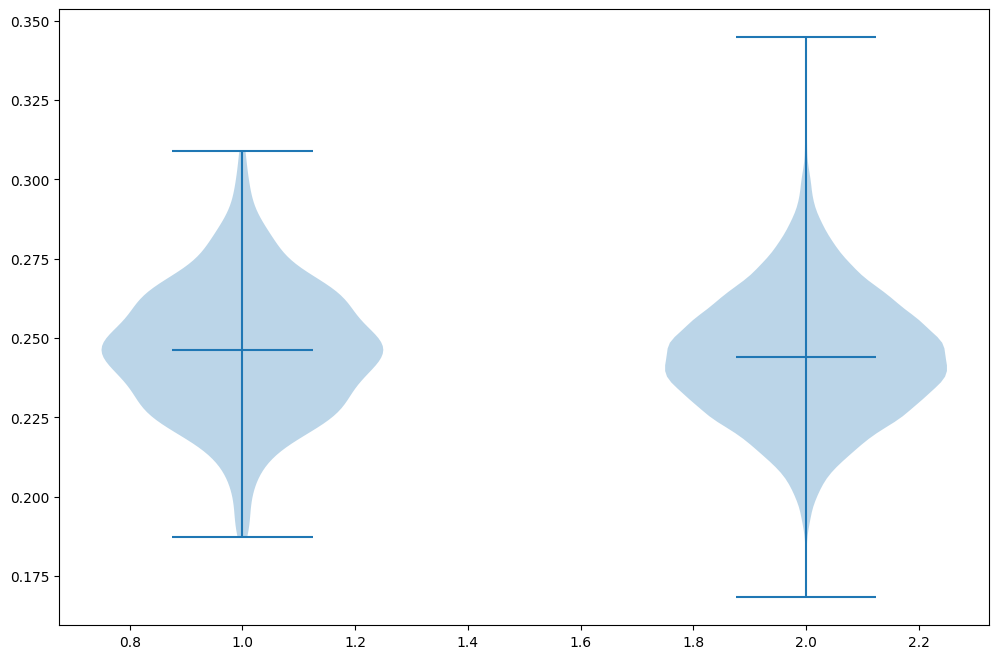

In [70]:
plt.clf()
plt.violinplot(
    [dyad_b1, nyad_b1],
    showmeans=True,
#     showmedians=True,
)
plt.show()



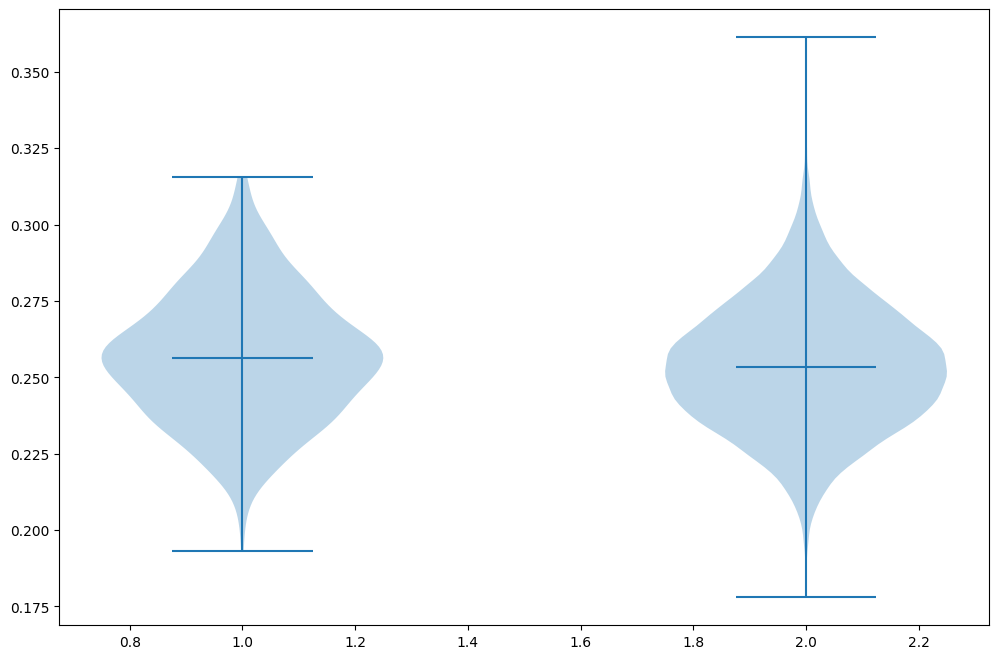

In [465]:
plt.clf()
plt.violinplot(
    [dyad_b2, nyad_b2],
    showmeans=True,
#     showmedians=True,
)
plt.show()



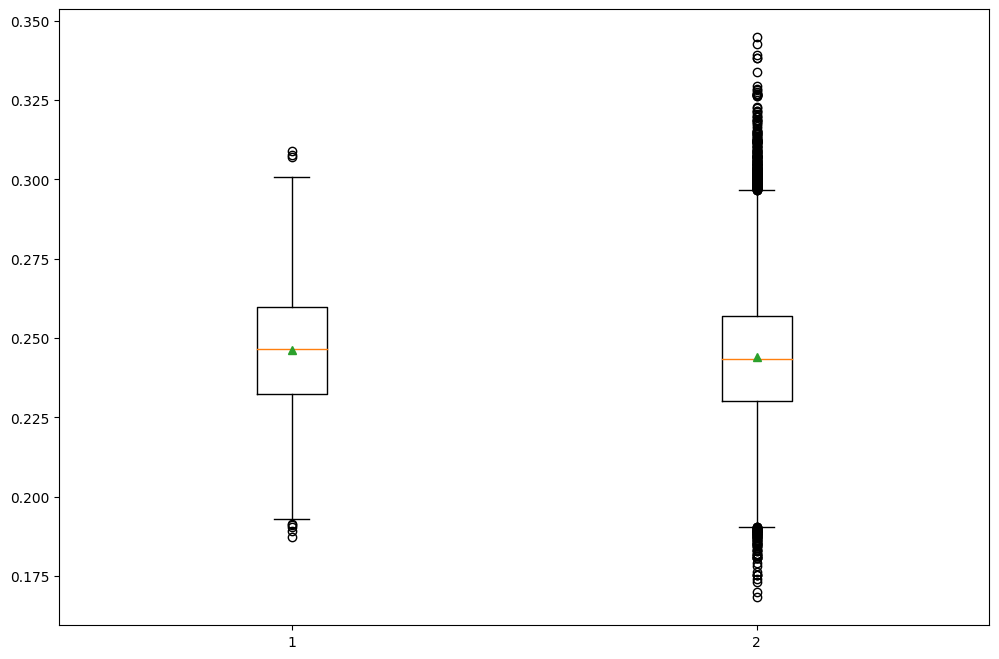

In [71]:
#synchrony values of real and non-real dyads plotted (Pre-Play)
plt.boxplot(
    [dyad_b1, nyad_b1],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [ ]:
#synchrony values of real and non-real dyads plotted (Puzzle)
plt.boxplot(
    [dyad_b2, nyad_b2],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [ ]:
#synchrony values of real and non-real dyads plotted (Pre-Play)
plt.boxplot(
    [dyad_b3, nyad_b3],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [ ]:
#T-TESTS ARE RAN HERE

In [204]:
from scipy.stats import ttest_ind

In [346]:
#Pre-Play T-test (Real vs False Dyads)
statistic, pvalue = ttest_ind(
    dyad_b1,
    nyad_b1)

In [347]:
statistic

2.8167893728435485

In [348]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.004852618973973095


In [501]:
#Puzzle T-test (Real vs False Dyads)
statistic, pvalue = ttest_ind(
    dyad_b2,
    nyad_b2)

In [502]:
statistic

3.738444080228915

In [503]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.0001853782211260365


In [478]:
#Post-Play T-test (Real vs False Dyads)
statistic, pvalue = ttest_ind(
    dyad_b3,
    nyad_b3)

In [479]:
statistic

3.1548064157667235

In [480]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.0016070405549626764


In [499]:
#Real vs Baseline (zeroes) --> switch the dyad to synchrony block of interest
statistic, pvalue = ttest_ind(
    nyad_b1,
    zyad_z1)

In [500]:
statistic

314.366715936745

In [498]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.0


In [ ]:
#2) HERE CAN TEST SPECIFIC ROIs (CHANNELS) BETWEEN REAL vs FALSE DYADS

In [76]:
#Use these cells below to test specific channels

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
  'S3_D2 hbo', # left frontal
  'S4_D2 hbo',
#   'S5_D3 hbo', # right frontal
#   'S6_D3 hbo',
#    'S1_D1 hbo', # left temporal
#    'S2_D1 hbo',
#    'S2_D2 hbo',
#    'S7_D3 hbo', #right temporal
#    'S7_D4 hbo',
#    'S8_D4 hbo'
]

dyad_c1 = [] # make a list for real dyads
nyad_c1 = [] # make a list for not-real dyads

# this is just using Block 1 = Pre-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in channels:
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_c1.append(
                sync_df[parent][real_child]['Block 1'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in channels:
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_c1.append(
                    sync_df[parent][false_child]['Block 1'][ch])

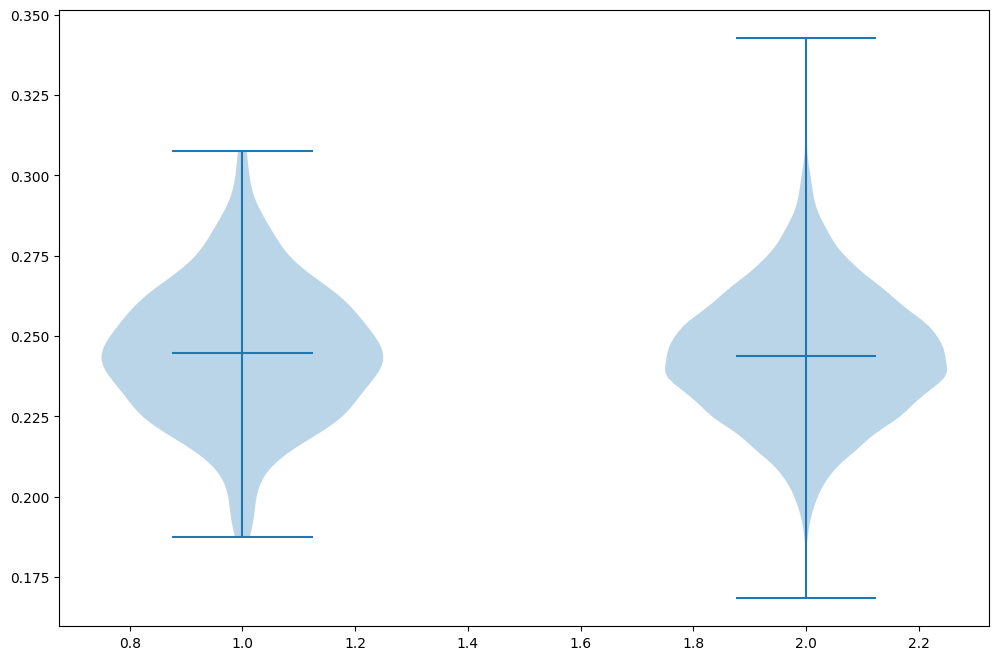

In [765]:
plt.clf()
plt.violinplot(
    [dyad_c1, nyad_c1],
    showmeans=True,
#     showmedians=True,
)
plt.show()



In [77]:
#Pre-Play T-test (Real vs False Dyads) - Specific Channels
statistic, pvalue = ttest_ind(
    dyad_c1,
    nyad_c1)

In [78]:
statistic

0.9571919176521076

In [79]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.33849403431828473


In [769]:
#Use these cells below to test specific channels

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
    'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
#      'S5_D3 hbo', # right frontal
#      'S6_D3 hbo',
     'S1_D1 hbo', # left temporal
     'S2_D1 hbo',
     'S2_D2 hbo',
#      'S7_D3 hbo', #right temporal
#      'S7_D4 hbo',
#      'S8_D4 hbo'
]

dyad_c2 = [] # make a list for real dyads
nyad_c2 = [] # make a list for not-real dyads

# this is just using Block 2 = Puzzle

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in channels:
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_c2.append(
                sync_df[parent][real_child]['Block 2'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in channels:
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_c2.append(
                    sync_df[parent][false_child]['Block 2'][ch])

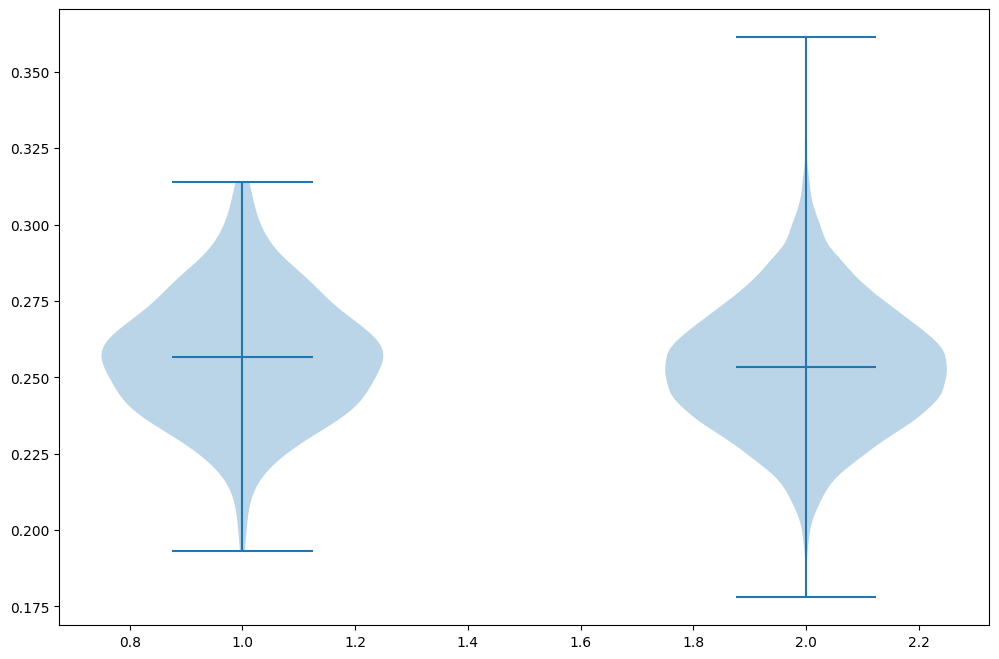

In [770]:
plt.clf()
plt.violinplot(
    [dyad_c2, nyad_c2],
    showmeans=True,
#     showmedians=True,
)
plt.show()



In [771]:
#Puzzle T-test (Real vs False Dyads) - Specific Channels
statistic, pvalue = ttest_ind(
    dyad_c2,
    nyad_c2)

In [772]:
statistic

2.885919792671518

In [773]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.0039062106155240777


In [774]:
#Use these cells below to test specific channels

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
      'S3_D2 hbo', # left frontal
      'S4_D2 hbo',
#       'S5_D3 hbo', # right frontal
#       'S6_D3 hbo',
      'S1_D1 hbo', # left temporal
      'S2_D1 hbo',
      'S2_D2 hbo',
#       'S7_D3 hbo', #right temporal
#       'S7_D4 hbo',
#       'S8_D4 hbo'
]

dyad_c3 = [] # make a list for real dyads
nyad_c3 = [] # make a list for not-real dyads

# this is just using Block 3 = Post-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in channels:
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_c3.append(
                sync_df[parent][real_child]['Block 3'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in channels:
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_c3.append(
                    sync_df[parent][false_child]['Block 3'][ch])

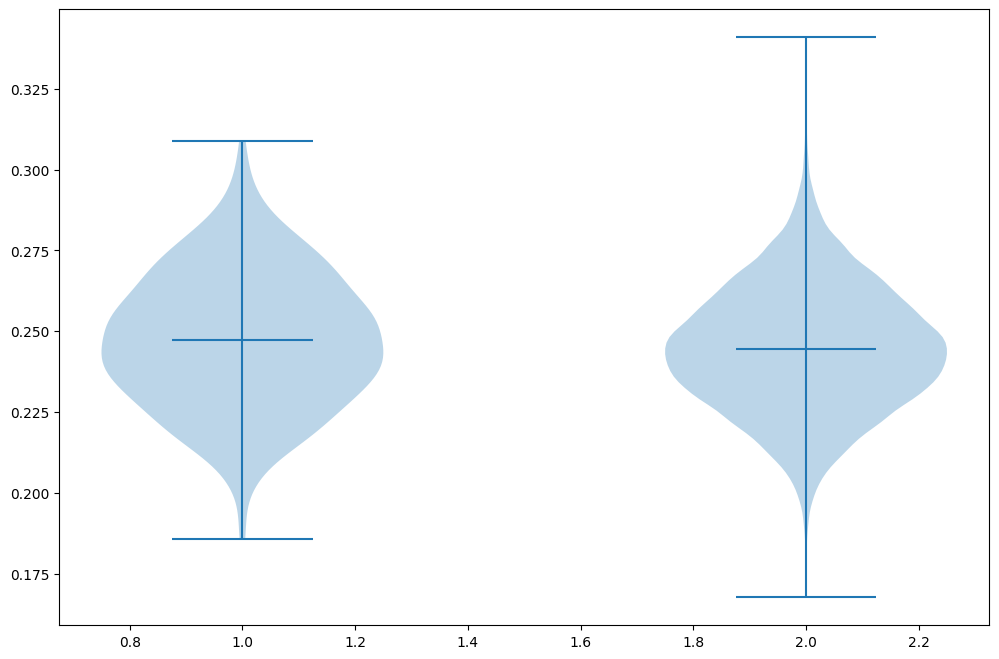

In [775]:
plt.clf()
plt.violinplot(
    [dyad_c3, nyad_c3],
    showmeans=True,
#     showmedians=True,
)
plt.show()



In [776]:
#Post-Play T-test (Real vs False Dyads) - Specific Channels
statistic, pvalue = ttest_ind(
    dyad_c3,
    nyad_c3)

In [777]:
statistic

2.5194987095506076

In [778]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.011758675822262775


In [ ]:
#TESTING BETWEEN BLOCK DIFFERECNES BETWEEN REAL DYADS (AVERAGE ACROSS ALL BLOCKS) THERE SHOULD BE 3 COMBINATIONS TOTAL

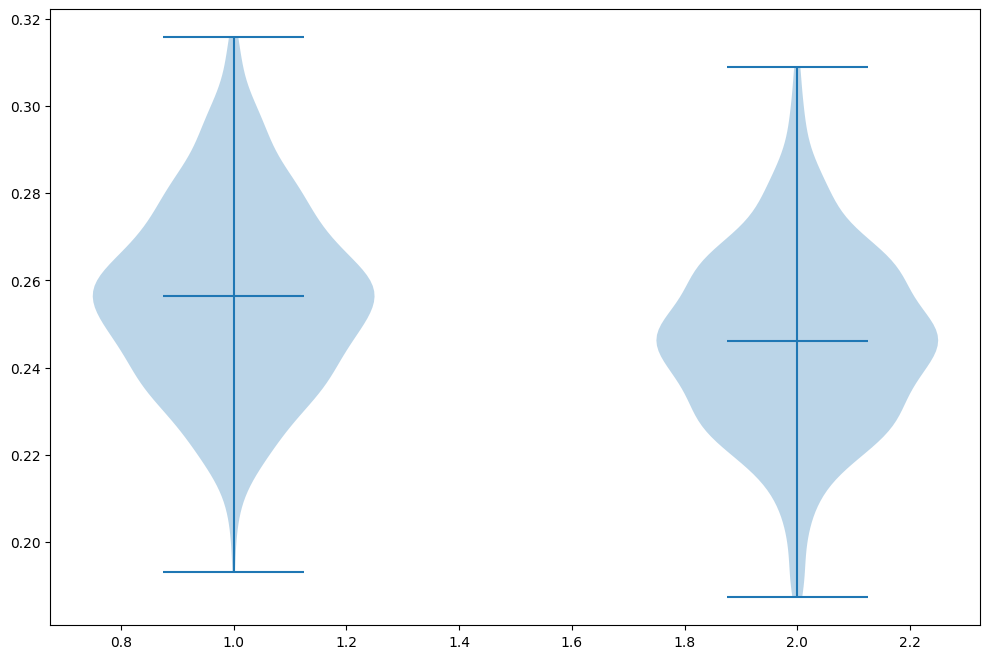

In [656]:
#Use the dyad variables created previously in the Real vs False Dyad analyses to test between Blocks

plt.clf()
plt.violinplot(
    [dyad_b2, dyad_b1],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [785]:
#T-test (Real vs False Dyads) 
statistic, pvalue = ttest_ind(
    dyad_c1,
    dyad_c3)

In [786]:
statistic

-1.5953645163129302

In [787]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.11111531985954747


In [ ]:
#INCORPORATION of eDOC SCORES BEGINS HERE

In [82]:
blocks = {
    'Block 1': 'Pre-Play',
    'Block 2': 'Puzzle',
    'Block 3': 'Post-Play',
}

COIs = [
    'OCYC_Total',
    'POPS_Total',
#     'total'
]

channels = [
     'S3_D2 hbo', # left frontal
     'S4_D2 hbo',
     'S5_D3 hbo', # right frontal
     'S6_D3 hbo',
     'S1_D1 hbo', # left temporal
     'S2_D1 hbo',
     'S2_D2 hbo',
     'S7_D3 hbo', # right temporal
     'S7_D4 hbo',
     'S8_D4 hbo'
]

In [213]:
# load eDOC CSV 
scores = pd.read_csv("/data/perlman/moochie/analysis/eDOC_NARSAD/eDOC_FUOvercontrol_ParentChildsav.csv")
scores['subject'] = [id for id in scores['subid']]
scores = scores.astype({'subject': 'str'})
scores = scores.mask(scores == ' ')
for COI in COIs:
    scores = scores.astype({COI: 'float'})
scores.set_index('subject', inplace=True)
scores.drop(columns=['subid'], inplace=True)

In [214]:
#OCYC = Overcontrol in Youth Checklist
#POPS = Pathological Obsessive Compulsive Personality Scale
scores

,OCYC_InflexFrust,OCYC_SocPerf,OCYC_Total,POPS_P_DwC,POPS_P_EO,POPS_P_RG,POPS_P_MP,POPS_P_RtD,POPS_Total
subject,,,,,,,,,
5000,1,1,2.0,26,19,38,34,34,151.0
5001,0,0,0.0,18,21,34,27,19,119.0
5003,5,7,12.0,14,13,31,26,20,104.0
5004,5,6,11.0,20,11,36,29,31,127.0
5005,3,2,5.0,27,16,42,36,38,159.0
...,...,...,...,...,...,...,...,...,...
5143,7,9,16.0,32,21,35,45,28,161.0
5144,1,1,2.0,18,8,33,25,30,114.0
5145,5,8,13.0,28,8,52,44,24,156.0


In [215]:
scores.columns

Index(['OCYC_InflexFrust', 'OCYC_SocPerf', 'OCYC_Total', 'POPS_P_DwC',
       'POPS_P_EO', 'POPS_P_RG', 'POPS_P_MP', 'POPS_P_RtD', 'POPS_Total'],
      dtype='object')

In [216]:
scores.index

Index(['5000', '5001', '5003', '5004', '5005', '5006', '5008', '5009', '5010',
       '5012',
       ...
       '5134', '5137', '5138', '5139', '5140', '5143', '5144', '5145', '5150',
       '5151'],
      dtype='object', name='subject', length=122)

In [217]:
# see how many rows there are in there
len([id for id in scores.index])

122

In [218]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

Coefficient of Determination: 0.013384264636110754
intercept: 0.24235712423024652
slope: [0.00035517]


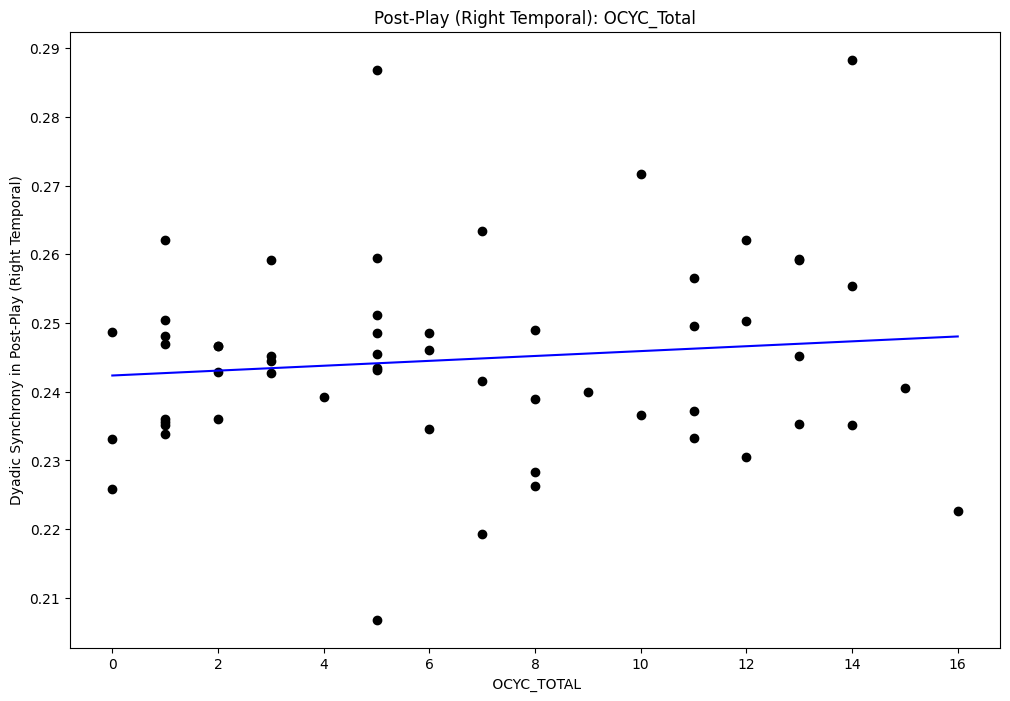

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7461
Date:                Mon, 06 Mar 2023   Prob (F-statistic):              0.391
Time:                        16:05:40   Log-Likelihood:                 161.64
No. Observations:                  57   AIC:                            -319.3
Df Residuals:                      55   BIC:                            -315.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2424      0.003     72.873      0.0

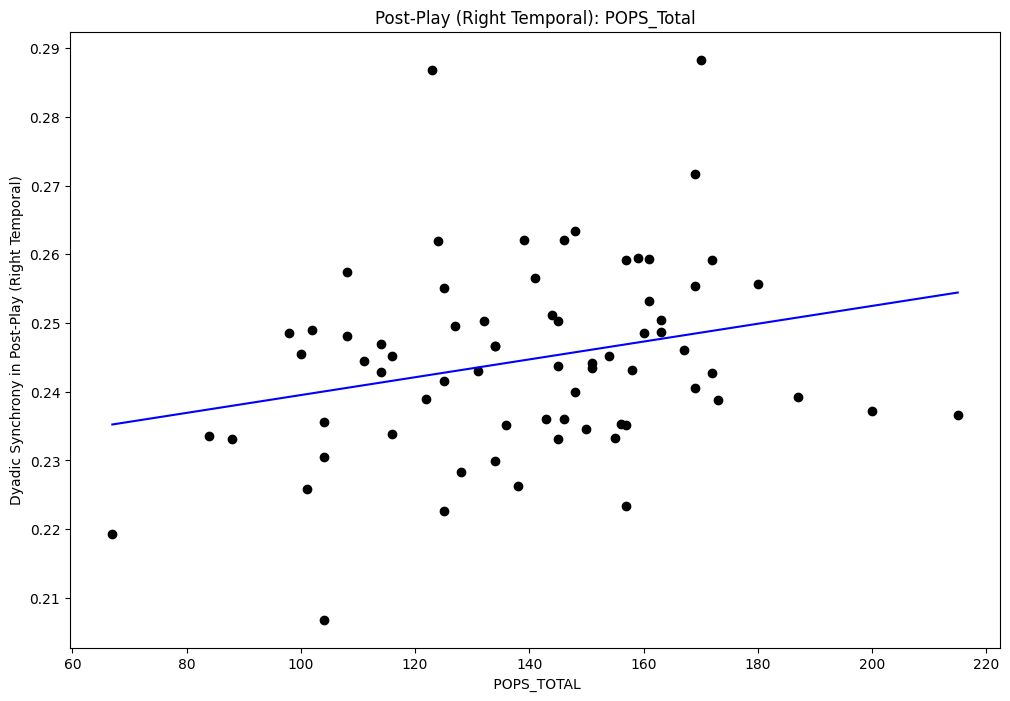

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     5.065
Date:                Mon, 06 Mar 2023   Prob (F-statistic):             0.0276
Time:                        16:05:41   Log-Likelihood:                 206.18
No. Observations:                  71   AIC:                            -408.4
Df Residuals:                      69   BIC:                            -403.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2265      0.008     27.578      0.0

In [219]:
# this is because, in the sync_df, we need to have a way to differentiate between the parent and child. so subject names are, e.g.
# 1234p or 1234c. Whereas, in your .csv / dataframe for other variables of interest, they are not specific to a parent or child, but a family. 
# so we often combine these values by looping over the parents (top level values in sync_df that end in "p"), and then reference that name,
# with the "p" replaced by "" (nothing) to access the correct value in the dataframe. 


channels = [
#      'S3_D2 hbo', # left frontal
#      'S4_D2 hbo',
#      'S5_D3 hbo', # right frontal
#      'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
     'S7_D3 hbo', # right temporal
     'S7_D4 hbo',
     'S8_D4 hbo'
]

#Set the Block of Interest here

block_num = 'Block 3'
block_name = 'Post-Play (Right Temporal)'

# Variant 1 (individual block)
# ==================
# for all the parent / child pairs who are listed in the scores .csv / dataframe,
#    and averaging over all the channels that are uncommented above
#    so this will yield a list called "syncs" which is as long as the number of parent / child pairs 
#    that are found in both sync_df and the scores dataframe
#    i.e. 1 averaged WTC value per dyad, specifically derived from whichever block is named in 
#    "block_num" above.


syncs = []
sync_parents = []
for parent in list(sync_df.keys()):
   dyad_syncs = []
   child = parent.replace('p', 'c')
   if parent.replace('p', '') in list(scores.index):
      for ch in channels:
         if ch not in bad_channels_dict[parent]:
            if ch not in bad_channels_dict[child]:
               dyad_syncs.append(sync_df[parent][child][block_num][ch])
   if len(dyad_syncs) > 0:
      syncs.append(np.average(dyad_syncs))
      sync_parents.append(parent)

# Variant 2 (block difference)
# ==================
# this version is doing the same thing, but specifically looking at the _difference_ of the WTC
#    in a dyad between two blocks. In this example, you can see that it is marking the difference
#    between sync of 'Block 2' and 'Block 1'. You are welcome to configure those variables 
#    as you see fit. The shape of the output list, syncs, will be the same as in Variant 1, and you
#    could use it just as well in any subsequent regressions, etc.  


# syncs = []
# sync_parents = []
# for parent in list(sync_df.keys()):
#    dyad_syncs = []
#    child = parent.replace('p', 'c')
#    if parent.replace('p', '') in list(scores.index):
#       for ch in channels:
#          if ch not in bad_channels_dict[parent]:
#             if ch not in bad_channels_dict[child]:
#                dyad_syncs.append(
#                   sync_df[parent][child]['Block 3'][ch] - \
#                   sync_df[parent][child]['Block 1'][ch])
#    if len(dyad_syncs) > 0:
#       syncs.append(np.average(dyad_syncs))
#       sync_parents.append(parent)


# Regression
# ================
# looping over the "columns of interest" which should be defined in a previous cell. as COIs = [ <stuff> ]
#     i.e., the names of any columns in your .csv you want to run regression on
for COI in COIs:

    # get the current variable of interest from the "scores" dataframe
    #    once again, only for subjects who are found in both the sync_df 
    #    and in the scores dataframe / .csv.
    voi = [scores.loc[[sub]][COI][0] for sub in [sub.replace('p', '') for sub in sync_parents]]

    # force the values read to be interpreted as float, as opposed to default string
    xnan = np.array(voi, dtype='float')
    ynan = np.array(syncs, dtype='float')

    # IQR correction if desired
#         # get IQR
#         q75, q25 = np.percentile(xnan, [75, 25])
#         intr_qr = q75 - q25
#         qmax = q75 + (1.5 * intr_qr)
#         qmin = q25 - (1.5 * intr_qr)
#         # remove the extra-IQR vals
#         xnan[xnan < qmin] = qmin
#         xnan[xnan > qmax] = qmin

    # remove any values that are NaN (hopefully none?) otherwise there
    #    may be issues in your .csv format 
    x = np.delete(xnan, np.where(np.isnan(xnan)))
    y = np.delete(ynan, np.where(np.isnan(xnan)))

    # Winsorize function (not recommended)
    # winsorize(y, inplace=True, limits=[0.05, 0.05])
    # winsorize(x, inplace=True, limits=[0.05, 0.05])

    # duplicate variables for use in regression (requires reshaping)
    X = x
    Y = y
    x = x.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    print(f"Coefficient of Determination: {r_sq}")
    print(f"intercept: {model.intercept_}")
    print(f"slope: {model.coef_}")

    # plot data
    plt.clf()
    plt.scatter(
        x,
        y,
        color='black')

    # plot regression line
    plt.plot(
        np.linspace(np.min(x), np.max(x)),
        model.predict(np.linspace(np.min(x), np.max(x)).reshape(-1, 1)),
        color='blue',
        linewidth=1.5)

    plt.xlabel(f" {COI.upper()}")
    plt.ylabel(f"Dyadic Synchrony in {block_name}")
    plt.title(f"{block_name}: {COI}")
    plt.show()
    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    print(est2.summary())